In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import IPython.display as display
import numpy as np
import random
import librosa
import librosa.display
import tensorflow as tf
import torchaudio
import torchvision
from torchvision import models, transforms
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset, DataLoader

C:\Users\Marc\anaconda3\lib\site-packages\torchaudio\extension\extension.py:13: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:

def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    for epoch in range(1, epochs+1):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim = 1)[1], targets)#.view(2)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))
def find_lr(model, loss_fn, optimizer, train_loader, init_value=1e-8, final_value=10.0, device="cpu"):
    number_in_epoch = len(train_loader) - 1
    update_step = (final_value / init_value) ** (1 / number_in_epoch)
    lr = init_value
    optimizer.param_groups[0]["lr"] = lr
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []
    for data in train_loader:
        batch_num += 1
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        # Crash out if loss explodes

        if batch_num > 1 and loss > 4 * best_loss:
            if(len(log_lrs) > 20):
                return log_lrs[10:-5], losses[10:-5]
            else:
                return log_lrs, losses

        # Record the best loss

        if loss < best_loss or batch_num == 1:
            best_loss = loss

        # Store the values
        losses.append(loss.item())
        log_lrs.append((lr))

        # Do the backward pass and optimize

        loss.backward()
        optimizer.step()

        # Update the lr for the next step and store

        lr *= update_step
        optimizer.param_groups[0]["lr"] = lr
    if(len(log_lrs) > 20):
        return log_lrs[10:-5], losses[10:-5]
    else:
        return log_lrs, losses        

In [4]:
print(torch.cuda.is_available())

False


In [5]:
display.Audio('ravdess/audio/03-01-01-01-01-01-01.wav')

ValueError: rate must be specified when data is a numpy array or list of audio samples.

In [6]:
PATH_TO_RAVDESS = Path.cwd() / "dat"
PATH_RAVDESS_TRAIN = PATH_TO_RAVDESS / "train"
PATH_RAVDESS_TEST = PATH_TO_RAVDESS / "test"

In [7]:
class PrecomputedRavdess(Dataset):
    def __init__(self,path,dpi=50, img_transforms=None):
        files = Path(path).glob('{}{}*.wav.png'.format(path.name, dpi))
        self.items = [(f,int(f.name.split("-")[2].replace(".wav.png",""))) for f in files]
        self.length = len(self.items)
        if img_transforms == None:
            self.img_transforms = transforms.Compose([transforms.ToTensor()])
        else:
            self.img_transforms = img_transforms
    
    def __getitem__(self, index):
        filename, label = self.items[index]
        img = Image.open(filename).convert('RGB')
        return (self.img_transforms(img), label)
            
    def __len__(self):
        return self.length

In [8]:
bs = 64
ravdess_train = PrecomputedRavdess(PATH_RAVDESS_TRAIN,
                                  img_transforms=transforms.Compose([
                                      transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])
)

ravdess_test = PrecomputedRavdess(PATH_RAVDESS_TEST,
                                  img_transforms=transforms.Compose([
                                      transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])
)

ravdess_train_loader = torch.utils.data.DataLoader(ravdess_train, bs, shuffle=True)
ravdess_test_loader = torch.utils.data.DataLoader(ravdess_test, bs, shuffle=True)

In [9]:
device = "cpu"
spec_resnet = models.resnet50(pretrained=True)

for param in spec_resnet.parameters():
    param.requires_grad = False

spec_resnet.fc = nn.Sequential(nn.Linear(spec_resnet.fc.in_features,500),
                               nn.ReLU(),
                               nn.Dropout(), nn.Linear(500,9))

In [10]:
spec_resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Labels: tensor([4, 4, 8, 2, 2, 8, 8, 7, 2, 2, 7, 4, 2, 7, 2, 7, 2, 2, 7, 8, 6, 8, 8, 7,
        6, 6, 4, 2, 7, 5, 8, 8, 6, 2, 6, 3, 2, 4, 6, 8, 4, 5, 2, 3, 6, 7, 3, 2,
        4, 4, 2, 8, 3, 6, 7, 8, 8, 1, 4, 8, 4, 4, 8, 6])


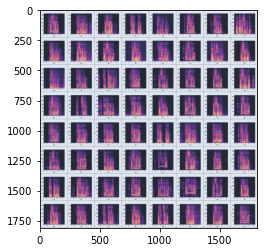

In [11]:
def imshow(img):
     img = img / 2 + 0.5
     npimg = img.numpy()
     plt.imshow(np.transpose(npimg, (1, 2, 0)))
     plt.show()
images, labels = next(iter(ravdess_train_loader))  
images_test, labels_test = next(iter(ravdess_test_loader))

print("Labels:",labels)

imshow(torchvision.utils.make_grid(images)/ 3)

In [12]:
labels.shape

torch.Size([64])

Text(0.5, 0, 'Lernrate')

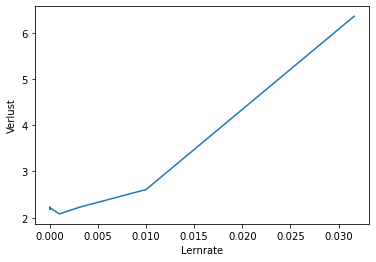

In [13]:
spec_resnet.to(device) 
torch.save(spec_resnet.state_dict(), "spec_resnet50.pth")
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(spec_resnet.parameters(), lr=0.001)
logs,losses = find_lr(spec_resnet, loss_fn, optimizer, ravdess_train_loader, device=device)
plt.plot(logs, losses)
plt.ylabel('Verlust')
plt.xlabel('Lernrate')

In [14]:
spec_resnet.load_state_dict(torch.load("spec_resnet50.pth"))

#optimizer = optim.Adam(spec_resnet.parameters(), lr=1e-2)
#train(spec_resnet, optimizer, nn.CrossEntropyLoss(), ravdess_train_loader, ravdess_test_loader, epochs = 50, device=device)

for param in spec_resnet.parameters():
    param.requires_grad = True
optimizer = optim.Adam([
                        {'params': spec_resnet.conv1.parameters()},
                        {'params': spec_resnet.bn1.parameters()},
                        {'params': spec_resnet.relu.parameters()},
                        {'params': spec_resnet.maxpool.parameters()},
                        {'params': spec_resnet.layer1.parameters(), 'lr': 1e-4},
                        {'params': spec_resnet.layer2.parameters(), 'lr': 1e-4},
                        {'params': spec_resnet.layer3.parameters(), 'lr': 1e-4},
                        {'params': spec_resnet.layer4.parameters(), 'lr': 1e-4},
                        {'params': spec_resnet.avgpool.parameters(), 'lr': 1e-4},
                        {'params': spec_resnet.fc.parameters(), 'lr': 1e-8}
                        ], lr=0.001)
train(spec_resnet, optimizer, nn.CrossEntropyLoss(), ravdess_train_loader, ravdess_test_loader, epochs = 30, device=device)

Epoch: 1, Training Loss: 2.07, Validation Loss: 1.88, accuracy = 0.40
Epoch: 2, Training Loss: 1.57, Validation Loss: 1.33, accuracy = 0.62
Epoch: 3, Training Loss: 1.09, Validation Loss: 1.26, accuracy = 0.62
Epoch: 4, Training Loss: 0.69, Validation Loss: 1.19, accuracy = 0.69
Epoch: 5, Training Loss: 0.47, Validation Loss: 0.90, accuracy = 0.77
Epoch: 6, Training Loss: 0.33, Validation Loss: 1.04, accuracy = 0.67
Epoch: 7, Training Loss: 0.27, Validation Loss: 0.96, accuracy = 0.72
Epoch: 8, Training Loss: 0.23, Validation Loss: 0.79, accuracy = 0.77
Epoch: 9, Training Loss: 0.19, Validation Loss: 0.95, accuracy = 0.73
Epoch: 10, Training Loss: 0.16, Validation Loss: 0.77, accuracy = 0.80
Epoch: 11, Training Loss: 0.15, Validation Loss: 0.70, accuracy = 0.80
Epoch: 12, Training Loss: 0.14, Validation Loss: 0.72, accuracy = 0.78
Epoch: 13, Training Loss: 0.10, Validation Loss: 0.62, accuracy = 0.83
Epoch: 14, Training Loss: 0.11, Validation Loss: 0.67, accuracy = 0.82
Epoch: 15, Trai

In [15]:
torch.save(spec_resnet.state_dict(),"pth_model50.pth")